In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [2]:
# Load the data
import json
import collections

datadict = collections.defaultdict(dict)
for record in SeqIO.parse("disprot_OK_fullset.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['seq'] = seq

for record in SeqIO.parse("disprot_OK_fullset_annotations.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['disorder'] = seq

print(f"Loaded {len(datadict.keys())} proteins")

Loaded 2145 proteins


In [4]:
AA2num = dict(zip(sorted(list(set([i for i in datadict["P19793"]['seq']]))),np.arange(20)))
AA2num['</s>'] = 20
AA2num['X'] = 21
num2AA = dict(zip(np.arange(20),sorted(list(set([i for i in datadict["P19793"]['seq']])))))
num2AA[20] = "</s>"
num2AA[21] = "X"
AAsize = len(list(AA2num.keys()))

uniprots = list(datadict.keys())
delcounter = 0
for unip in uniprots:
    lossfile = f"loss/{unip}.json"
    if os.path.exists(lossfile):
        #print(unip)
        with open(lossfile) as instrm:
            lossdict = json.load(instrm)
        datadict[unip]["aamask_1"] = lossdict[unip]["aamask_1"]
    else:
        del(datadict[unip])
        delcounter += 1

print(f"Loaded {len(datadict.keys())} proteins")

Loaded 2145 proteins


In [17]:
### Do a per-region analysis
import copy

def get_regions(diso_ix):
    local_acum = 0
    current_status = None
    this_regions = list()
    for e in diso_ix:
        if current_status is None:
            current_status = copy.copy(e)
            local_acum += 1
        if e is current_status:
            local_acum += 1
        else:
            this_regions.append([local_acum, current_status])
            current_status = e
            local_acum = 1
    this_regions.append([local_acum, current_status])
    return this_regions
    
protlengths = list()
regions_dict = dict()
regions_disorder_length = list()
regions_order_length = list()
regions_disorder_length_large = list()
regions_order_length_large = list()
for unip in datadict:
    L = len(datadict[unip]['seq'])
    protlengths.append(L)
    this_seq = datadict[unip]['seq']
    diso_ix = [True if e != "-" else False for e in datadict[unip]['disorder'] ]
    #loss = np.array(datadict[unip]['aamask_1']['loss'])
    #matches = datadict[unip]['aamask_1']['match']
    #seq_pos = np.arange(len(matches))
    regions = get_regions(diso_ix) # [(378, False), (12, True), (38, False), (22, True), (63, False)]
    if L < 700:
        regions_dict[unip] = regions
        for r in regions:
            if r[1]:
                regions_disorder_length.append(r[0])
            else:
                regions_order_length.append(r[0])
    else:
        #regions_dict[unip] = regions
        for r in regions:
            if r[1]:
                regions_disorder_length_large.append(r[0])
            else:
                regions_order_length_large.append(r[0])

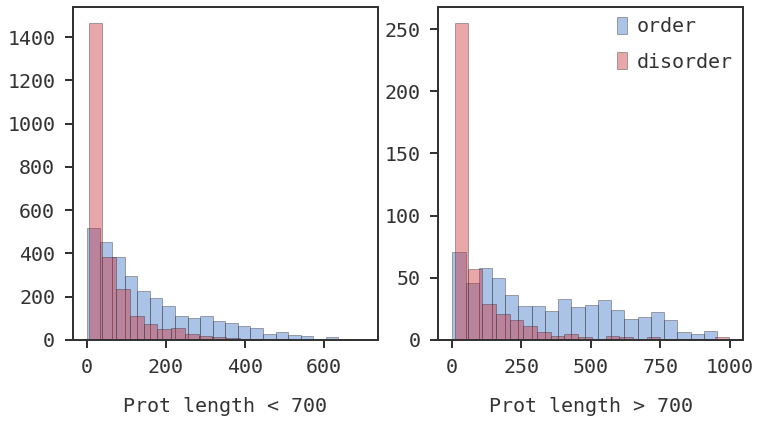

In [20]:
# regions length distribution

fig = plt.figure(figsize=(12,6), dpi=72)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(regions_order_length, label="order", alpha=0.4)
ax1.hist(regions_disorder_length, label="disorder", alpha=0.4)
ax1.set_xlabel("Prot length < 700")
ax2.hist(regions_order_length_large, label="order", alpha=0.4)
ax2.hist(regions_disorder_length_large, label="disorder", alpha=0.4)
ax2.set_xlabel("Prot length > 700")
plt.legend()
plt.show()

In [26]:

disordered_region_match_acum = list()
ordered_region_match_acum    = list()
for unip in regions_dict:
    matches = datadict[unip]['aamask_1']['match']
    start_acum = 0
    for region in regions_dict[unip]:
        if region[1]: #disordered region
            this_matches = matches[start_acum:start_acum+region[0]]
            for i,m in enumerate(this_matches):
                if m:
                    disordered_region_match_acum.append(i/region[0])
        else:
            this_matches = matches[start_acum:start_acum+region[0]]
            for i,m in enumerate(this_matches):
                if m:
                    ordered_region_match_acum.append(i/region[0])
        start_acum += region[0]

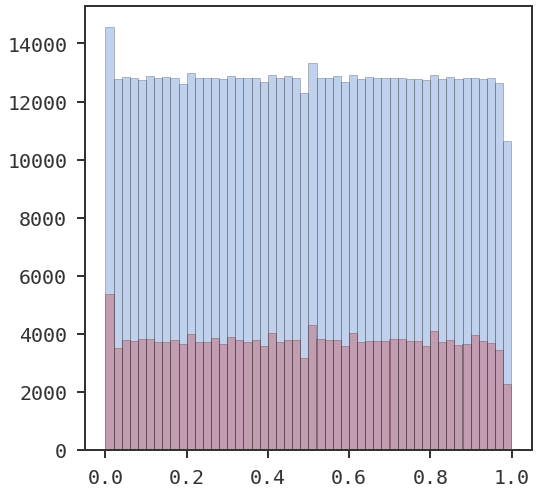

In [30]:
fig = plt.figure(figsize=(8,8), dpi=72)
plt.hist(ordered_region_match_acum, bins=50, alpha=0.3)
plt.hist(disordered_region_match_acum, bins=50, alpha=0.3)
plt.show()